In [2]:

import numpy as np
from obspy.core.trace import Trace
from matplotlib import pyplot as plt
import time
import os 
import cwt
from utilities.cwt import *


Add notes on data 

### Load data from paper implementation. 

windows have shape (286, 15000): 286 channels and 5 minute window length. Windows overlap by 2.5 minutes so 7500 samples. 

In [3]:
#load data with shape (nchannels, nSamples)
window_one = np.load("./TestData/stanford_numpy/2016-09-02_23:59:54training_prep.npy")
window_two =np.load("./TestData/stanford_numpy/2016-09-03_00:01:54training_prep.npy")

print("data shape: ", window_one.shape)

data = np.concatenate([window_one, window_two], axis=1, dtype=np.float64)
print(data.shape)

data shape:  (286, 15000)
(286, 30000)


### Parameter for CWT that will be used later 

window_size: the length of the cwt window in seconds

n_channels: the number of channels in the data 

n_samples: the total samples in the data

n_features: number of features per sample after performing cwt 30 will be on the time axis 30 will be on the spacial axis

samples_per_second: samples taken per second at each channel

samples_within_average: the amount of cwt features that will be average per set in the final output

n_sub_samples: n_samples/samples_within_average amount of samples that will be in the final output

delta: 1/samples_per_second or the sample period 

freq_min: min frequency allowed through bandpass filter 

freq_max: max frequency allowed through bandpass filter

freq_min_space: min frequency used for the spatial scales of cwt 

freq_max_space: max frequency used for spatial scales of cwt

time_scales: scales for time cwt 

spatial_scales: scales for spatial cwt



In [4]:
window_size = 300
n_channels = data.shape[0]
n_samples = data.shape[1]
n_features = 60
samples_per_second = 50
samples_within_average = 25
n_sub_samples = int(n_samples / samples_within_average)
delta = 1.0 / float(samples_per_second)
freq_min = 0.2
freq_max = 24.0
freq_min_space= 0.04
freq_max_space= 2
w0 =8

time_log = np.logspace(np.log10(freq_min), np.log10(freq_max), 30)
space_log = np.logspace(np.log10(freq_min_space), np.log10(freq_max_space), 30)

#time_scales = cwt.scales_from_fourier(time_log, wf="morlet", w0=8)
#spatial_scales = cwt.scales_from_fourier(space_log, wf="morlet", w0=8)
print(n_channels)
print(n_samples)

286
30000


## This transforms one window of data 

In [5]:
scales = (time_log*(w0 + np.sqrt(2 + w0**2)))/ (4 * np.pi)
scales

array([ 0.25662204,  0.30268428,  0.35701443,  0.42109654,  0.49668103,
        0.58583253,  0.69098622,  0.81501442,  0.96130499,  1.13385391,
        1.3373744 ,  1.5774257 ,  1.86056487,  2.19452595,  2.5884312 ,
        3.05304026,  3.60104407,  4.24741153,  5.00979836,  5.90902941,
        6.96966744,  8.22068413,  9.69625138, 11.43667478, 13.48949453,
       15.91078406, 18.76668163, 22.135197  , 26.10834221, 30.79464498])

### Perform cwt on two windows of data 

In [6]:
dir = "./TestData/stanford_numpy"
file_list = os.listdir(dir)
sorted_list = sorted(file_list)
sorted_list = sorted_list[1:]
print(sorted_list)

count = 1
for file in sorted_list:
    data = np.load(dir+ "/"+ file)
    result = transform_window(data, n_channels, samples_per_second, samples_within_average, space_log, scales )
    
    filename = file.split(".")[0]
    np.save("cwt_" + filename, result)
    if(count == 2):
        break
    else:
        count+=1

['2016-09-02_23:59:54training_prep.npy', '2016-09-03_00:01:54training_prep.npy']


filter took 3.9215927124023438
torch.Size([286, 1, 30])


/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities/cwt.py:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  multiplied = wavelet.T * fft_signal[None,:,:]


space cwt took 18.22025227546692
signal shape is torch.Size([286, 14999])
scales shape is torch.Size([30])
torch.Size([286, 14999])
wavelet shape is torch.Size([14999, 30])
fft shape is torch.Size([286, 14999])
time cwt took 24.01352286338806
filter took 0.9487028121948242
torch.Size([286, 1, 30])
space cwt took 7.255063056945801
signal shape is torch.Size([286, 14999])
scales shape is torch.Size([30])
torch.Size([286, 14999])
wavelet shape is torch.Size([14999, 30])
fft shape is torch.Size([286, 14999])
time cwt took 24.54137873649597


In [7]:

result = np.empty((n_channels, 600, 60), dtype=np.float64)
#window one is len of 15000 samples or 5 minutes 
result[:,:300,:] = np.load("cwt_2016-09-02_23:59:54training_prep.npy")
#window two is the same size but shifted 2.5 minutes from window 1
result[:,300:,:] = np.load("cwt_2016-09-03_00:01:54training_prep.npy")



Normalize data by removing mean and scale variance to 1

In [8]:

#Do normilization 
trainingData = result
print(f'shape of data before normalization reshape {trainingData.shape}')
trainingData = np.reshape(trainingData, (n_channels * trainingData.shape[1], -1))
print(f'shape after rshape {trainingData.shape}')

#does the same thing as the papers sklearn 
trainingData = (trainingData - np.mean(trainingData, axis=0, keepdims=True)) / np.std(trainingData, axis=0, keepdims=True)
normed_data = trainingData.reshape(n_channels, 600, 60)
print(f'final shape {normed_data.shape}')

shape of data before normalization reshape (286, 600, 60)
shape after rshape (171600, 60)
final shape (286, 600, 60)


In [9]:
#calculate the scales for graphs 

minFrq = 0.5
maxFrq = 24
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
nf = 30
# logspace from paper implemenation 
ftime = np.logspace(np.log10(minFrq), np.log10(maxFrq), nf)
fspace = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), nf)

wf = "morlet"
w0 = 8

#scales from paper implementation 
time_scales = cwt.scales_from_fourier(ftime, wf , w0)
scalesSpace = cwt.scales_from_fourier(fspace, wf, w0)


#are these pseudo frequencies ? 
time_fourier = cwt.fourier_from_scales(time_scales, wf, w0)
space_fourier = cwt.fourier_from_scales(scalesSpace, wf, w0)

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_928/3079092801.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


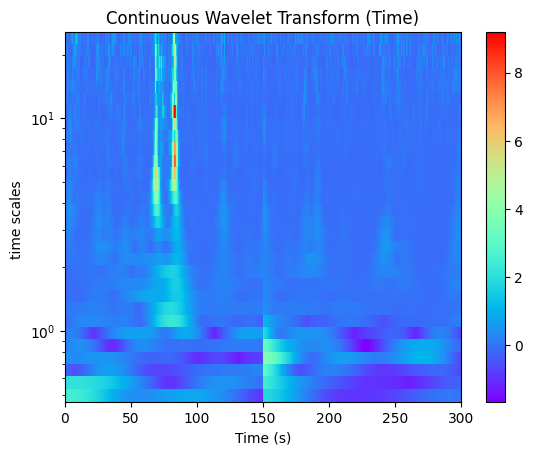

In [10]:

time_data = normed_data[127][:,:30]

time_graph = np.linspace(0, 300, 600)
fig, axs = plt.subplots()


pcm = axs.pcolormesh(time_graph, time_fourier[::-1], time_data.T, shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("time scales ")
axs.set_title("Continuous Wavelet Transform (Time)")
fig.colorbar(pcm, ax=axs)
fig.show()


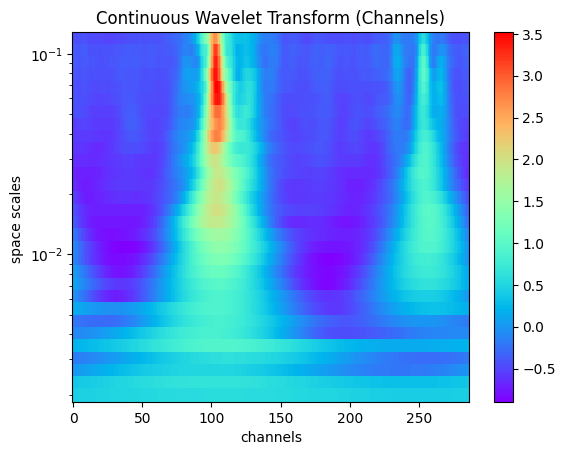

In [11]:
channels_data = normed_data[:,100,30:]

channels = np.linspace(0, 286, 286)
fig, axs = plt.subplots()
pcm = axs.pcolormesh(channels, space_fourier[::-1], channels_data.T,  shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("channels")
axs.set_ylabel("space scales ")
axs.set_title("Continuous Wavelet Transform (Channels)")
fig.colorbar(pcm, ax=axs)

In [12]:
def sub_sample(data):
    data =np.reshape(data[:, 250: 7750], (data.shape[0], 300, 25))
    return np.mean(data, axis=2)

(600,)


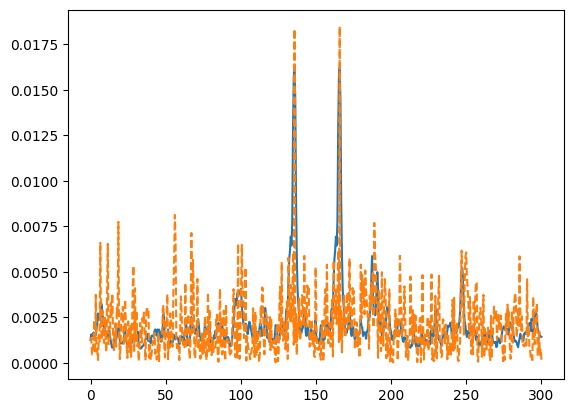

In [34]:
    #calculate the scales for cwt
scales = (time_log*(w0 + np.sqrt(2 + w0**2)))/ (4 * np.pi)

diff = data[:-1] - data[1:]

o_signal = window_one[0]
o_signal = o_signal[1:] - o_signal[:-1]
o_signal -= np.mean(o_signal)
o_signal = sub_sample(o_signal[None, :])
o_signal = np.squeeze(o_signal)

o_signal2 = window_two[0]
o_signal2 = o_signal2[1:] - o_signal2[:-1]
o_signal2 -= np.mean(o_signal2)
o_signal2 = sub_sample(o_signal2[None, :])
o_signal2 = np.squeeze(o_signal2)

combo = np.abs(np.concatenate((o_signal, o_signal2)))

signal = inverse_cwt(transform.T, scales, dj=.01, dt=0.5, w0=w0)

t = np.linspace(0, 300, 600)

plt.plot(t, signal)
plt.plot(t, combo, ls='--')

print(combo.shape)
